In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
import runner
import umm
from imp import reload

In [4]:
reload(runner)
instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.9"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=5
seed=2
budget=200
m_ini=10
budgetMM=10
# ratio_samples_learn=0.10
# weight_mass_learn=0.9
res = []
np.set_printoptions(linewidth=np.nan)
for ratio_samples_learn in [.1]:
  for weight_mass_learn in [0.9]:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                         ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
    res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
    print("best found",df.Fitness.min())
    #out_filename="local_new_CEGO"
    #runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

Generating synthetic LOP instance with seed=123456 n=20 m=200 phi=0.9
identity, reverse and best-known fitnesses 100.75999999999999 89.24 None
best found 0.0039752650176679925


instance name LOP-synthetic,seed=123456,n=20,m=200,phi=0.9 - time 58.09
0.0039752650176679925


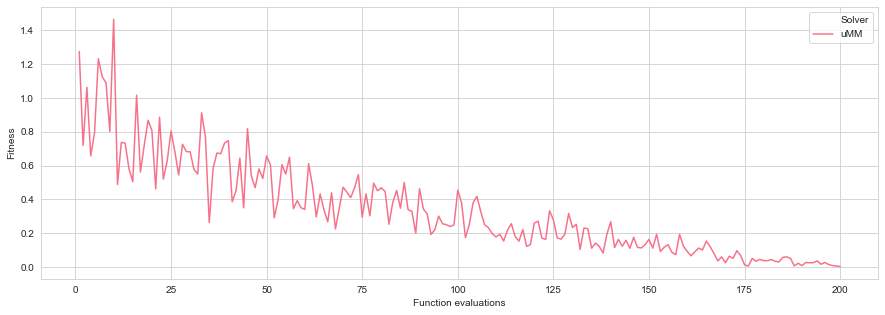

In [5]:
# instance_name="pfsp/rec05.txt"
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')
#dfc, dfu = pd.read_pickle('local_new_CEGO.pkl.gz'),pd.read_pickle('local_new_uMM.pkl.gz');df = pd.concat([dfc, dfu]) 

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
sns.set_style("whitegrid")
print(df.Fitness.min())
# 'pickles/pickLocal.pkl')#pick570618.pkl

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    plt.show()

# Real data umm

we have executed umm with a grid of parameters ratio_samples_learn & weight_samples_learn. We load the min found in the execution in `df` and the best known solutions in `best`. (The best know for the real data LOP are give as a maximitaion problem so this value has to be corrected)



In [10]:
find_in_lop_folder('N-be75eec', ret_value='path'),find_in_lop_folder('N-be75eec_150', ret_value='path')

('lop/IO/N-be75eec', 'lop/xLOLIB/N-be75eec_150')

In [6]:
def find_in_lop_folder(instance_name, ret_value='instance'):
  import os
  for fol in os.listdir("lop"):
    if os.path.isdir("lop/"+fol):
      for file in os.listdir("lop/"+fol):
          if instance_name == file:
              path = "lop/"+fol+"/"+file
              with open(path) as f:
                n = int(f.readline().strip())
                instance = np.loadtxt(f, max_rows=n)
              if ret_value == 'instance' : return instance
              if ret_value == 'path': return path
  return None
#find_in_lop_folder('N-t1d100.01')

df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
df = df.reset_index()

best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
# cambia los de la carperta LOP 
for instance_name in best.instance_name:
  inst = find_in_lop_folder(instance_name)
  if inst is not None:
    ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
#     print(ins, be)
    best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
best

dfres = pd.merge(best,df,left_on='instance_name', right_on='filename')
dfres['min_norm'] = dfres.best_amin / dfres.best_known_global
dfres



,instance_name,best_known_global,filename,ratio,weight,best_amin,best_mean,best_std,min_norm
0,N-p50-01,16673.0,N-p50-01,0.05,0.500000,20164.0,21497.900000,683.004710,1.209380
1,N-p50-01,16673.0,N-p50-01,0.05,0.554444,20320.0,21823.600000,854.238088,1.218737
2,N-p50-01,16673.0,N-p50-01,0.05,0.608889,20576.0,21465.111111,609.357745,1.234091
3,N-p50-01,16673.0,N-p50-01,0.05,0.663333,20063.0,21145.000000,563.367849,1.203323
4,N-p50-01,16673.0,N-p50-01,0.05,0.717778,20157.0,21202.700000,670.499822,1.208961
...,...,...,...,...,...,...,...,...,...
408,rec19,2325.0,rec19,0.25,0.772222,2377.0,2423.100000,26.404755,1.022366
409,rec19,2325.0,rec19,0.25,0.826667,2381.0,2408.800000,12.541487,1.024086
410,rec19,2325.0,rec19,0.25,0.881111,2344.0,2400.800000,33.372643,1.008172
411,rec19,2325.0,rec19,0.25,0.935556,2367.0,2407.300000,30.007592,1.018065


## which ratio_samples_learn & weight_samples_learn is the best for each instance?

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

Overall, we can say that `ratio_samples_learn=0.1` and `weight_samples_learn=0.9` is a reasonable choice

N-p50-01


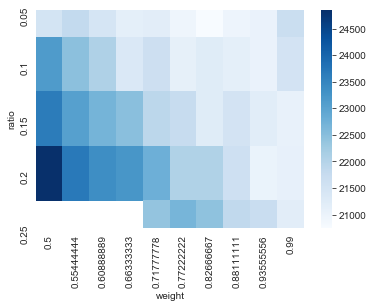

N-p50-02


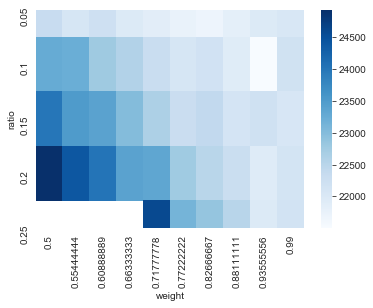

N-atp111


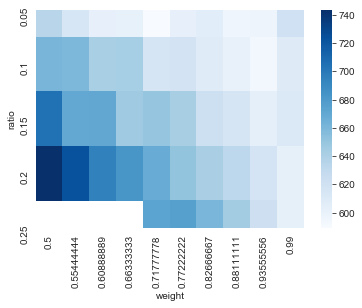

N-atp134


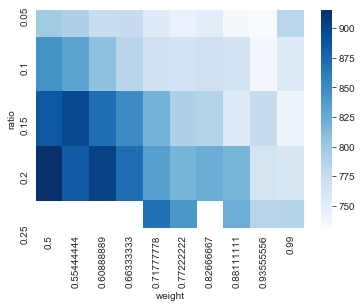

tho30


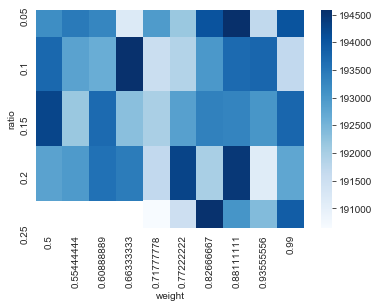

kra32


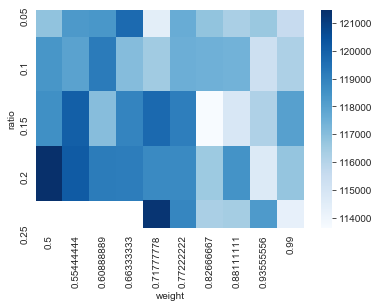

nug30


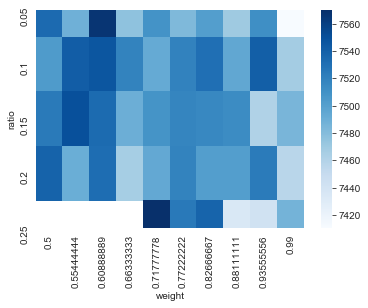

nug12


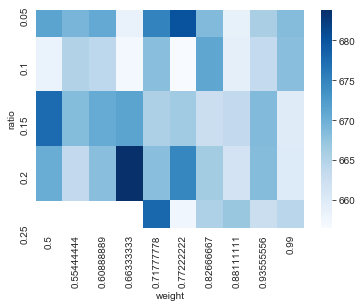

rec19


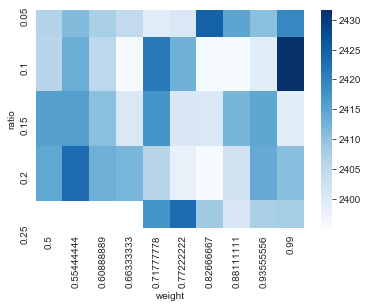

In [56]:
for instance_name in dfres.instance_name.drop_duplicates().values:
  print(instance_name)
  square = dfres[dfres.instance_name == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
  sns.heatmap(square, cmap="Blues")
  plt.show()

## run best
run the best param configuration for each instance and plot the converge. The best parameters for a particular instance are given by `best_params = dfres.loc[dfres.groupby('instance_name').best_mean.idxmin()]`

N-atp111 0.05 0.71777778 356.0
Reading instance from lop/Spec/N-atp111
The best fitnesses are not load (lop.py), uncomemnt the following lines
identity, reverse and best know fitnesses 980.0 871.0 None
835.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


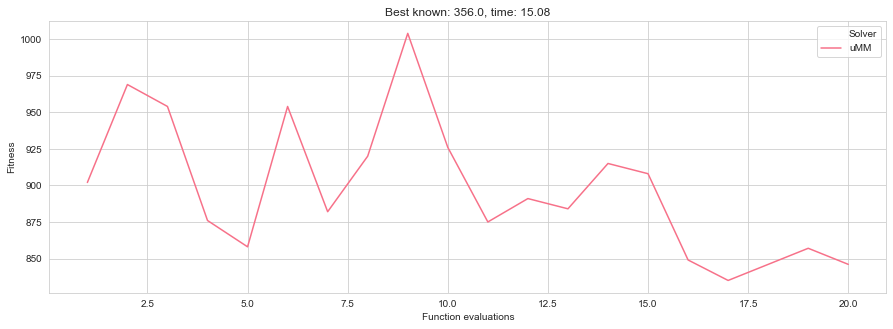

N-atp134 0.05 0.93555556 439.0
Reading instance from lop/Spec/N-atp134
The best fitnesses are not load (lop.py), uncomemnt the following lines
identity, reverse and best know fitnesses 1139.0 1096.0 None
1004.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


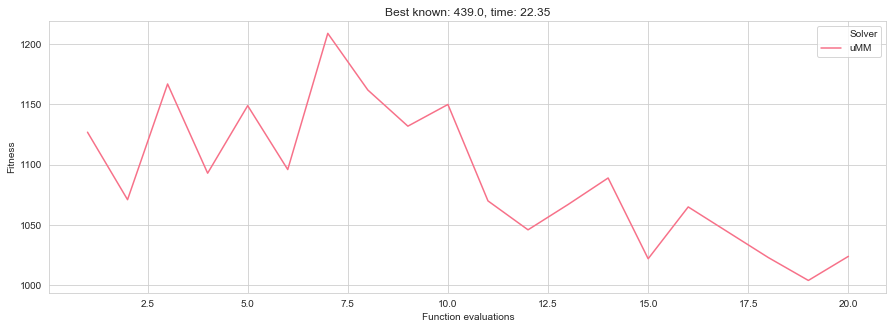

N-p50-01 0.05 0.82666667 16673.0
Reading instance from lop/RandB/N-p50-01
The best fitnesses are not load (lop.py), uncomemnt the following lines
identity, reverse and best know fitnesses 29166.0 32174.0 None
27076.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


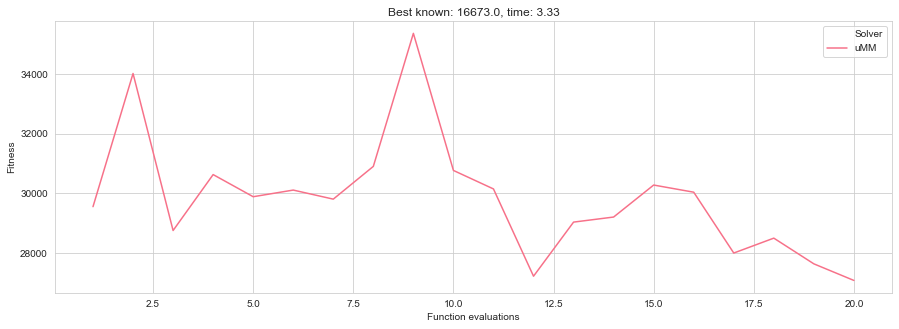

N-p50-02 0.1 0.93555556 17269.0
Reading instance from lop/RandB/N-p50-02
The best fitnesses are not load (lop.py), uncomemnt the following lines
identity, reverse and best know fitnesses 29242.0 31862.0 None
25939.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


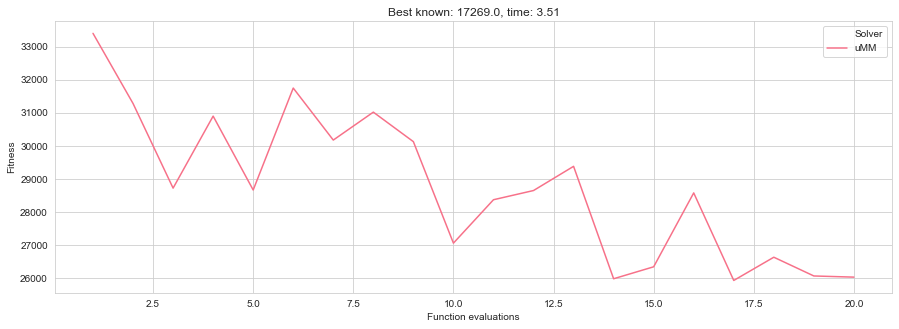

kra32 0.15 0.82666667 112000.0
nug12 0.1 0.77222222 620.0
nug30 0.05 0.99 7200.0
rec19 0.2 0.88111111 2325.0
tho30 0.2 0.93555556 180000.0


In [20]:
best_params = dfres.loc[dfres.groupby('instance_name').best_mean.idxmin()]


budgetGA=5
seed=2
budget=20
m_ini=10
budgetMM=10
for index, row in best_params.iterrows():
    print(row.filename, row.ratio, row.weight, row.best_known_global)
    if "N-" in row.filename: 
      instance_name, ratio_samples_learn, weight_mass_learn = row.filename, row.ratio, row.weight
      instance_name = find_in_lop_folder(instance_name, ret_value='path')
      
      out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
      out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
      df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                       ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
      sns.set_style("whitegrid")
      print(df.Fitness.min())
      color_variable = 'Solver'
      y_variables = ['Fitness']
      palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
      for y_variable in y_variables:
          plt.figure(figsize=(15,5))
          pl = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
          pl.set_title("Best known: "+str(row.best_known_global)+", time: "+ str(round(df.run_time.iloc[0], 2)))
          plt.savefig(out_filename.replace("pickles","img")+".jpg")
          plt.show()
    

# Compare cego and umm

1 qap/kra32.dat


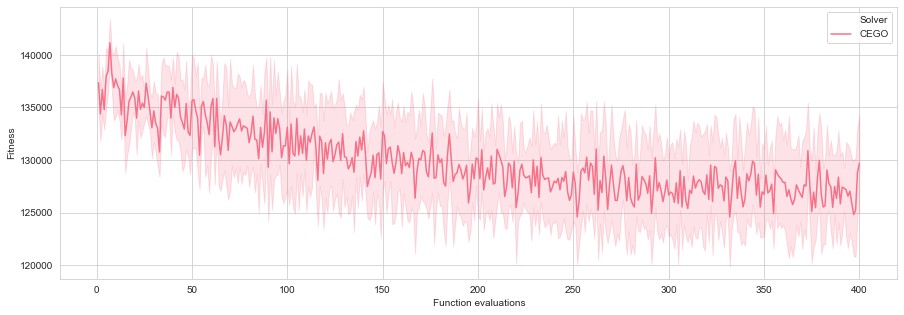

2 qap/nug12.dat


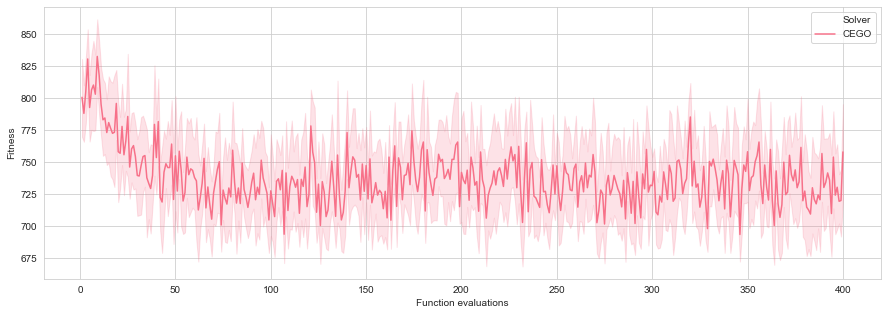

3 qap/nug30.dat


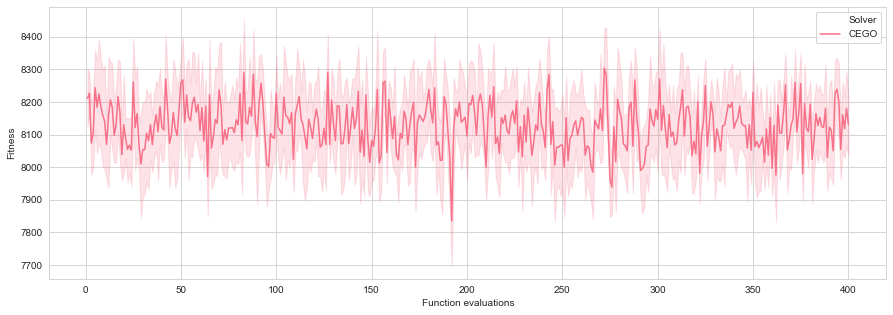

4 qap/tho30.dat


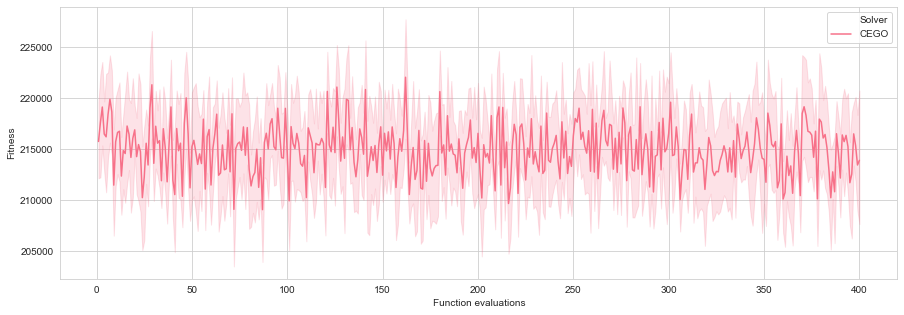

5 pfsp/rec05.txt


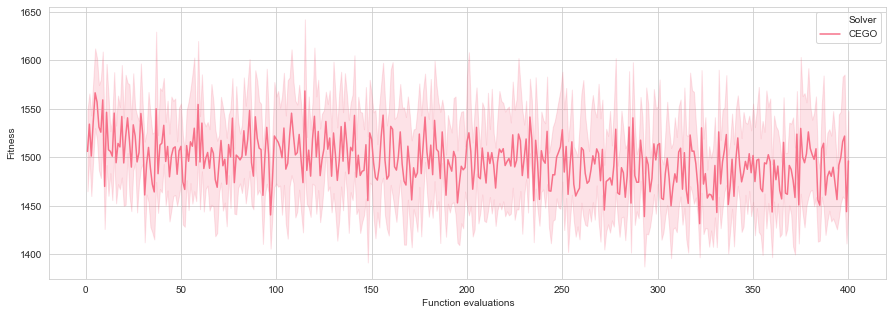

6 pfsp/rec13.txt


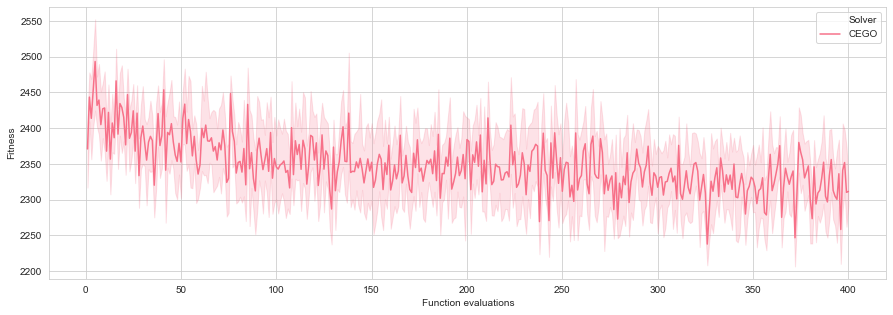

7 pfsp/rec19.txt


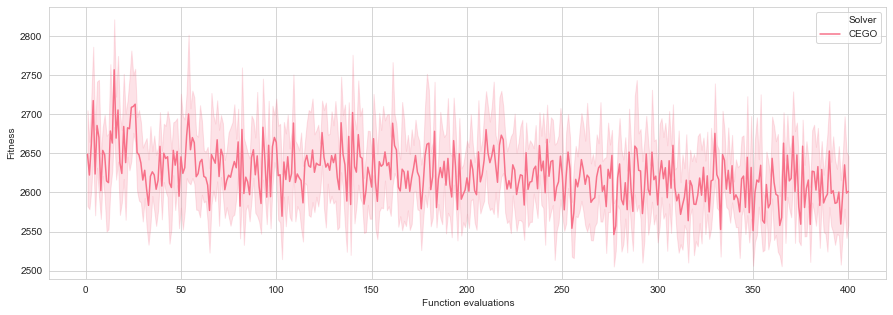

9 LOP-synthetic,seed=123456,n=20,m=200,phi=0.5
10 LOP-synthetic,seed=123456,n=20,m=200,phi=0.7
11 LOP-synthetic,seed=123456,n=20,m=200,phi=0.9


In [28]:
# which instances are solved with CEGO??
import os
for i in range(1,12):
  if i != 8:
    df = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') 
                    if 'pkl'in filename and 'cego-'+str(i)+'-' in filename])
    print(i, df.instance.iloc[0])
    if i < 8 :
      sns.set_style("whitegrid")
      color_variable = 'Solver'
      y_variables = ['Fitness']#,'Distance','phi_sample'
      palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
      for y_variable in y_variables:
          plt.figure(figsize=(15,5))
          g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
          plt.savefig('img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.jpg')
          plt.show()

In [29]:
dfumm[['ratio_samples_learn', 'weight_mass_learn','phi_instance']].drop_duplicates()

,ratio_samples_learn,weight_mass_learn,phi_instance
0,0.2307,0.8825,0.5
0,0.1698,0.8297,0.7
0,0.1503,0.8362,0.5
0,0.2224,0.8295,0.7
0,0.1503,0.8362,0.7
0,0.2224,0.8295,0.9
0,0.1698,0.8297,0.5
0,0.2224,0.8295,0.5
0,0.1698,0.8297,0.9
0,0.2307,0.8825,0.7


ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM '
 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


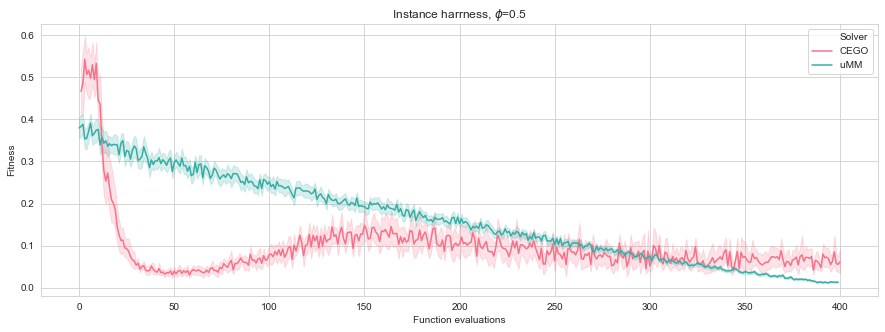

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM '
 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


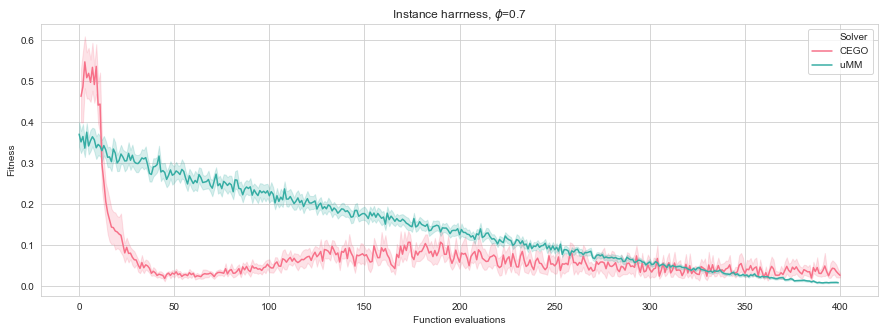

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'CEGO' 'uMM '
 'CEGO' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


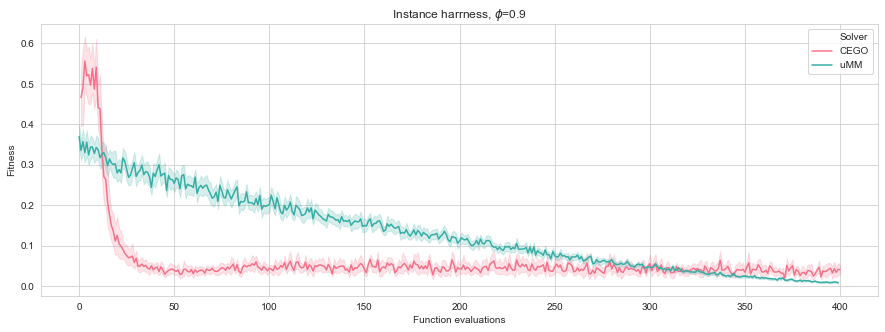

In [58]:

# COmpare in synthetic data
# Compare the convergence to lowest fitness funtion values by the two solvers

dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]


for phi in [0.5, 0.7, 0.9]: 
  
  df = pd.concat([dfcego[dfcego.instance.str.contains('phi='+str(phi))], dfumm[dfumm.phi_instance==phi]],sort=False)
  sns.set_style("whitegrid")
  print("ranking of the solvers by fitness")
  print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
  color_variable = 'Solver'
  y_variables = ['Fitness']#,'Distance','phi_sample'
  palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
  for y_variable in y_variables:
      plt.figure(figsize=(15,5))
      g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
      g.set_title(r'Instance harrness, $\phi$='+str(phi))
      plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
      plt.show()


In [31]:
# Compare in real data, QAP and LOP
# with the above results we can justify that a reasonable param configuration is weight=0.9 and ratio = 0.1
# we run the real data with these parameters
# for the PFSF and QAP the results of the best one are not conclusive

dfNoLopCEGO = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(0,9) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename])
t = dfNoLopCEGO.instance.str.split('/').str[-1]
dfNoLopCEGO['instance'] = t.str.split('.').str[0]


dfNoLopUMM = pd.read_csv('results/results.csv',index_col=0)
dfNoLopUMM.columns = [c if c!='min' else 'best' for c in dfNoLopUMM.columns]
dfNoLopUMM = dfNoLopUMM[(abs(dfNoLopUMM.weight-0.93)<0.01)&(dfNoLopUMM.ratio==0.1)] # ocn los parametros elegidos
pd.pivot_table(dfNoLopUMM,index=['filename'],values='best',aggfunc=np.mean)

dfNoLopUMM = pd.pivot_table(dfNoLopUMM,index=['filename'],values='best',aggfunc={np.mean,np.std}).reset_index()
dfNoLopUMM.columns = ['instance','mean_of_bests_umm','std_of_bests_umm']
dfNoLopUMM

dfNoLopCEGO = dfNoLopCEGO.groupby(['instance']).Fitness.mean().reset_index()
bests_compare = pd.merge(dfNoLopCEGO, dfNoLopUMM)
# dfNoLopUMM = pd.pivot_table(dfNoLopUMM,index=['filename'],values='best',aggfunc=np.mean)
# dfNoLopUMM.columns = ['best_'+ c for c in dfNoLopUMM.columns]
# dfNoLopUMM = dfNoLopUMM.reset_index()
# dfNoLopUMM
# bestsCEGO = dfNoLopCEGO.groupby(['Solver','instance']).Fitness.mean().reset_index()
# bests_compare = pd.merge(bestsCEGO,dfNoLopUMM, left_on='instance', right_on='filename')
bests_compare['diff(positive->umm wins)'] = bests_compare.Fitness - bests_compare.mean_of_bests_umm
bests_compare
# bests_compare

,instance,Fitness,mean_of_bests_umm,std_of_bests_umm,diff(positive->umm wins)
0,kra32,129935.5150,115291.0,4318.874468,14644.5150
1,nug12,737.7015,663.6,16.269945,74.1015
2,nug30,8127.8540,7541.0,77.023806,586.8540
3,rec05,1496.8245,1322.3,19.402463,174.5245
4,rec13,2348.9500,2161.6,18.927934,187.3500
5,rec19,2624.0890,2399.2,21.513820,224.8890
6,tho30,214948.2620,193763.8,2024.515843,21184.4620


In [13]:
dfNoLopCEGO.groupby(['instance']).Fitness.mean().reset_index()

,instance,Fitness
0,kra32,129935.5150
1,nug12,737.7015
2,nug30,8127.8540
3,rec05,1496.8245
4,rec13,2348.9500
5,rec19,2624.0890
6,tho30,214948.2620


In [25]:
lopumm = pd.read_csv('results/results.csv',index_col=0)
lopumm = lopumm[lopumm.filename.str.startswith("N-")]
lopumm.filename.drop_duplicates()

0           N-atp111
800         N-atp134
3285        N-t2d150
3593        N-p50-01
3634        N-p50-02
4641        N-t1d100
5921        N-t1d150
6818    N-be75np-150
Name: filename, dtype: object

# REAL LOP
10:41


lop/RandA1/N-t1d100.01
pickles/lop__RandA1__N-t1d100.01.pkl.gz


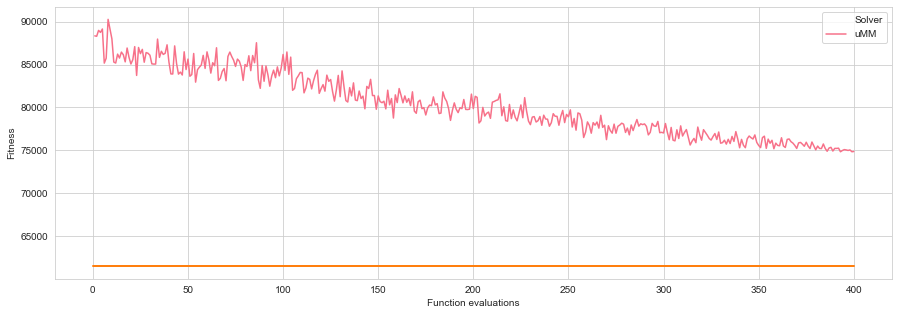

lop/RandA1/N-t1d100.02
pickles/lop__RandA1__N-t1d100.02.pkl.gz


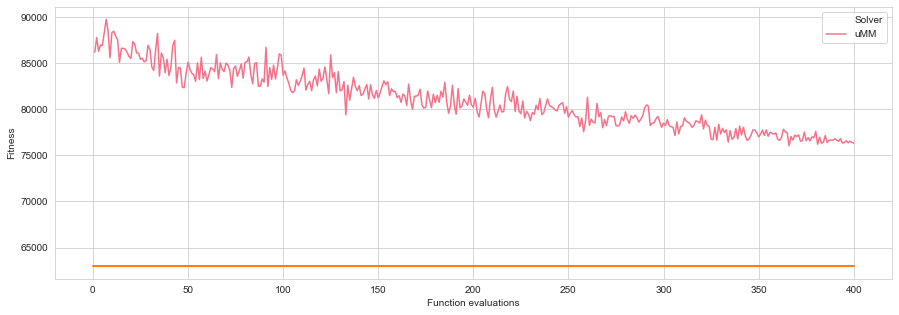

lop/RandA1/N-t1d150.01
pickles/lop__RandA1__N-t1d150.01.pkl.gz


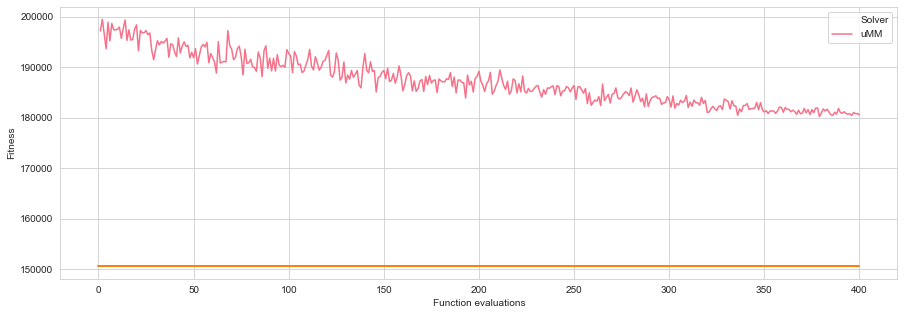

lop/RandA1/N-t1d150.02
pickles/lop__RandA1__N-t1d150.02.pkl.gz


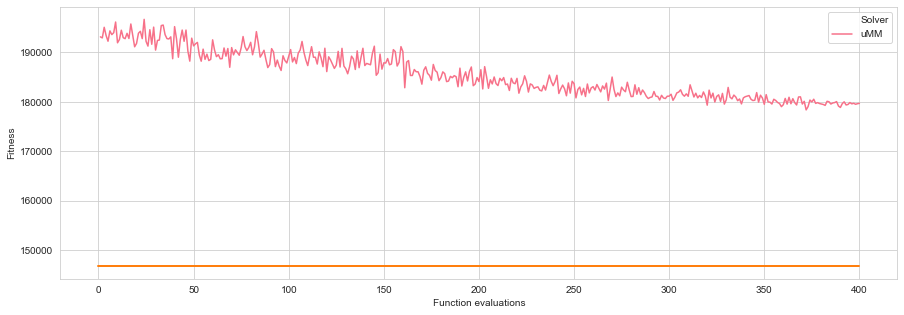

lop/RandA1/N-t1d200.01
pickles/lop__RandA1__N-t1d200.01.pkl.gz


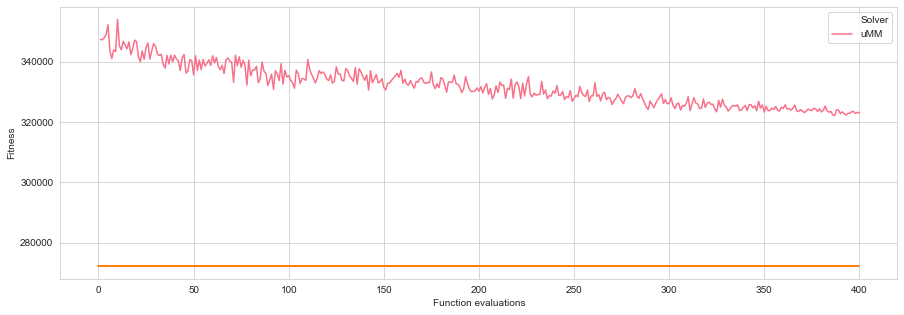

lop/RandA1/N-t1d200.02
pickles/lop__RandA1__N-t1d200.02.pkl.gz


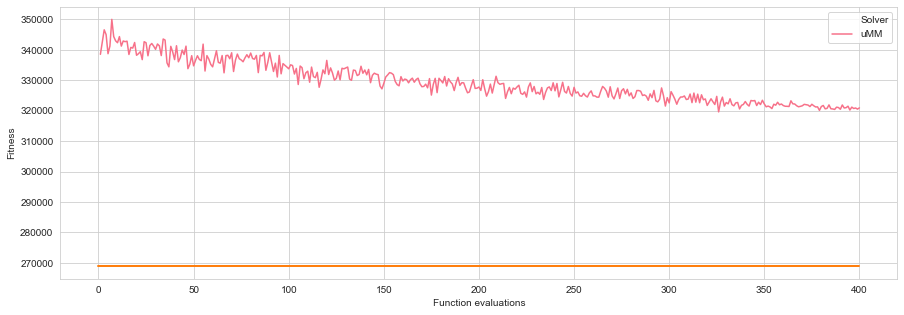

lop/RandA2/N-t2d150.01
pickles/lop__RandA2__N-t2d150.01.pkl.gz


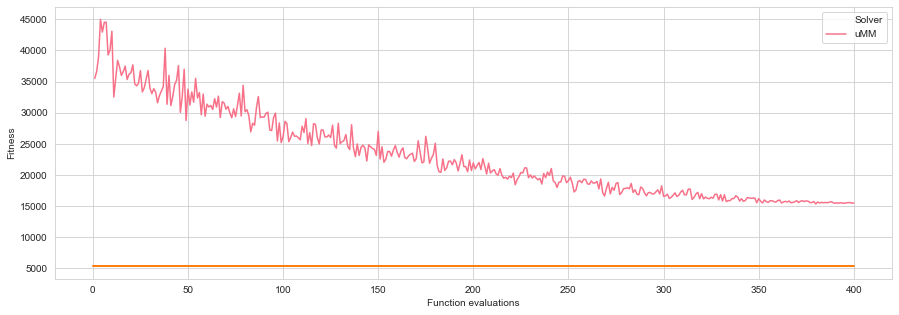

lop/RandA2/N-t2d150.02
pickles/lop__RandA2__N-t2d150.02.pkl.gz


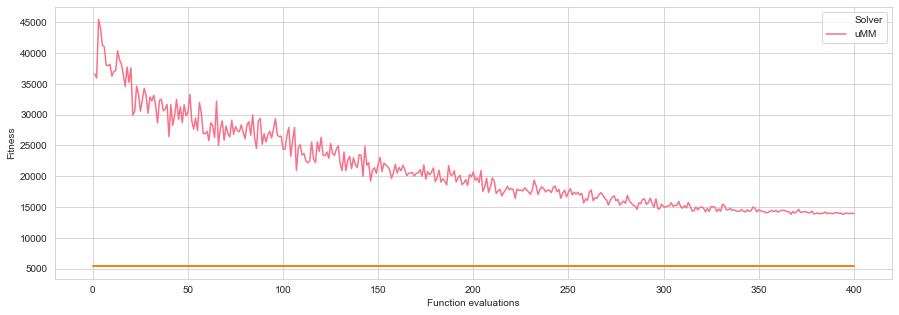

lop/RandA2/N-t2d200.01
pickles/lop__RandA2__N-t2d200.01.pkl.gz


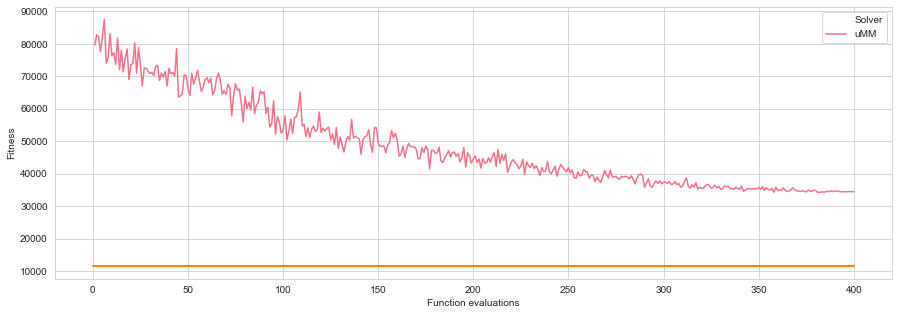

lop/RandA2/N-t2d200.02
pickles/lop__RandA2__N-t2d200.02.pkl.gz


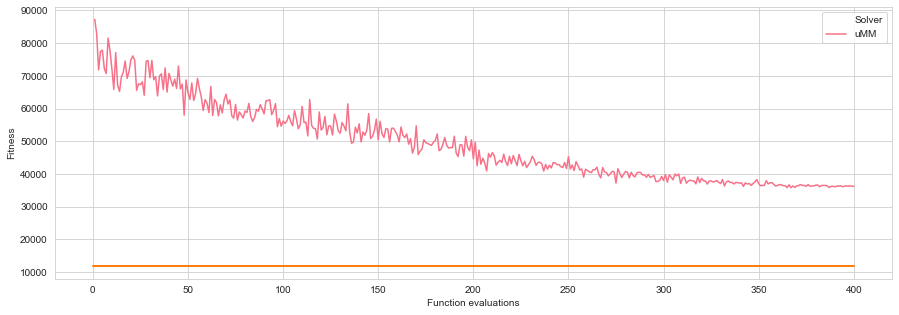

lop/RandB/N-p50-01
pickles/lop__RandB__N-p50-01.pkl.gz
lop/RandB/N-p50-02
pickles/lop__RandB__N-p50-02.pkl.gz
lop/xLOLIB/N-be75eec_150
pickles/lop__xLOLIB__N-be75eec_150.pkl.gz


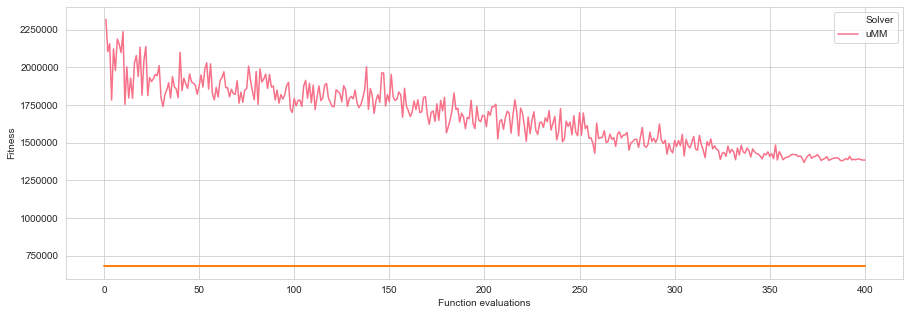

lop/xLOLIB/N-be75np_150
pickles/lop__xLOLIB__N-be75np_150.pkl.gz


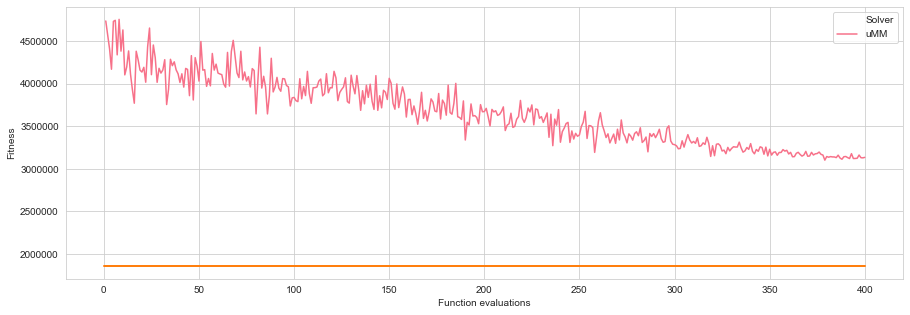

lop/xLOLIB/N-be75eec_250
pickles/lop__xLOLIB__N-be75eec_250.pkl.gz


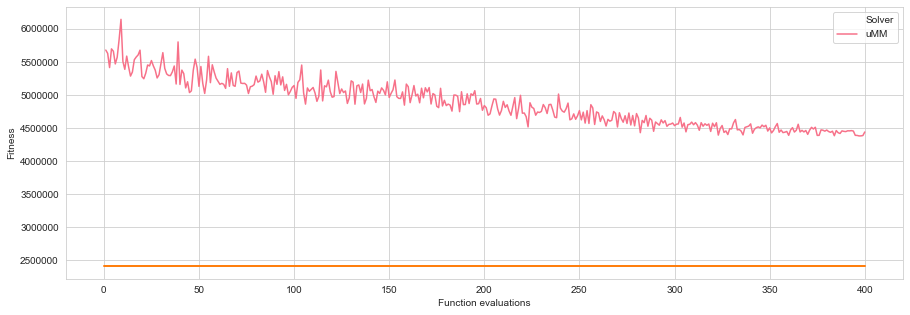

lop/xLOLIB/N-be75np_250
pickles/lop__xLOLIB__N-be75np_250.pkl.gz


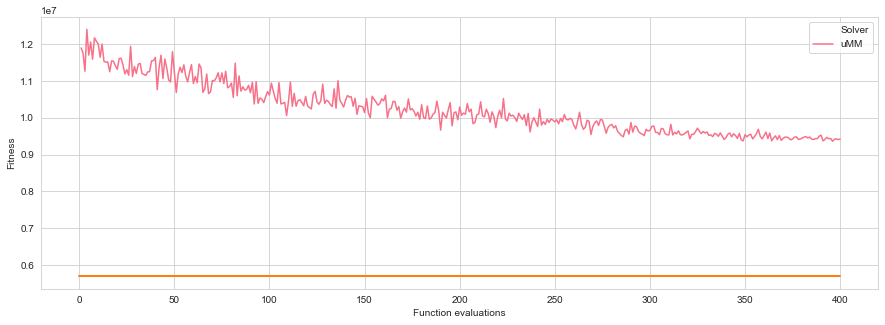

lop/Spec/N-atp111
pickles/lop__Spec__N-atp111.pkl.gz
lop/Spec/N-atp134
pickles/lop__Spec__N-atp134.pkl.gz


In [60]:
from pathlib import Path
best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
# cambia los de la carperta LOP 
for instance_name in best.instance_name:
  inst = find_in_lop_folder(instance_name)
  if inst is not None:
    ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
    best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
best = best[best.instance_name.str.startswith('N-')]
best
for ind, row in best.iterrows():
  out_filename = find_in_lop_folder(row.instance_name, ret_value='path')
  print(out_filename)
  out_filename = "pickles/"+out_filename.replace("/", "__").replace(".txt", "")+'.pkl.gz'
  if not Path(out_filename).exists():
    print("NOT FINISHED",out_filename)
  else:
    print(out_filename)
    df = pd.read_pickle(out_filename)
    sns.set_style("whitegrid")
  #   print("ranking of the solvers by fitness")
  #   print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
    color_variable = 'Solver'
    y_variables = ['Fitness']#,'Distance','phi_sample'
    palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
    if df['Function evaluations'].max() >350:
      for y_variable in y_variables:
          plt.figure(figsize=(15,5))
          g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
          g.plot([0, 400], [row.best_known_global, row.best_known_global], linewidth=2)
    #       g.set_title(r'Instance harrness, $\phi$='+str(phi))
    #       plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
          plt.show()


In [26]:

df = pd.read_pickle('pickles/lop__xLOLIB__N-be75np_250.pkl.gz')
df.run_time.iloc[0]/3600

9.46353439868583